Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE


url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)



def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('\nData size %d' % len(words))


vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('\nMost common words (+UNK)', count[:5])
print('\nSample data', data[:10])

print ("words[3] : " + str(words[3]))
print ("data[3] : " + str(data[3]))
print ("dictionary['a'] : " + str(dictionary['a']))
print ("reverse_dictionary[6] : " + str(reverse_dictionary[6]))
print ("count[6] : " + str(count[6]))

# 'words' is the list of ALL words composing the corpus
# 'data' is a list containing the index in 'dictionnary' of ALL word of 'words'
# 'dictionary' is the dictionary of the 50 000 most commons words (named the MAIN words) and their associated occurrence rank (order by occurrence rank)
# 'reverse_dictionary' is the symetric of 'dictionary' ie switch the 'dictionary(key/value)' == 'reverse_dictionary(value/key)'
# 'count' is a dict, ordered by word occurrence rank, mapping each MAIN word to its number of occurrence

del words  # Hint to reduce memory.

Found and verified text8.zip

Data size 17005207

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]

Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
words[3] : a
data[3] : 6
dictionary['a'] : 6
reverse_dictionary[6] : a
count[6] : ('a', 325873)


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch_SG(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(4, 2),(2, 1),(1, 1),(2, 3)]:
    data_index = 0
    batch, labels = generate_batch_SG(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'a', 'originated', 'of', 'as', 'originated', 'term']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 1 and skip_window = 1:
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']
    labels: ['as', 'a', 'as', 'of', 'abuse', 'of', 'used', 'against']

with num_skips = 2 and skip_window = 3:
    batch: ['a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse']
    labels: ['term', 'originated', 'first', 'abuse', 'first', 'term', 'against', 'used']


Train a skip-gram model.

Initialized
Average loss at step 0: 7.899304
Nearest to history: stipulate, tabletop, socialist, spiced, hartford, convocation, xxx, mandible,
Nearest to be: falun, hippies, waza, brooding, deposited, lucca, airshows, alc,
Nearest to new: outlying, wharf, worldly, isothermal, believable, specializes, convents, keystroke,
Nearest to are: accomplishes, hansa, basis, forensics, vertigo, abiotic, postmillennialism, contexts,
Nearest to no: ect, maghrib, hundreds, default, eek, rampant, unfulfilled, seaton,
Nearest to they: guerra, goodman, mouthpieces, hayward, locusts, stephen, pentagon, imprinted,
Nearest to years: conspiratorial, multiprocessor, believed, intellectual, wessex, recognising, morales, discount,
Nearest to also: advocated, enzyte, frankfort, cddb, imposition, squid, preventing, dolby,
Nearest to known: universals, sholom, rocked, galvani, eln, flaubert, stands, masonry,
Nearest to seven: tycho, herbivores, amur, dominatrix, honours, sadr, alessandro, yupik,
Nearest to many:

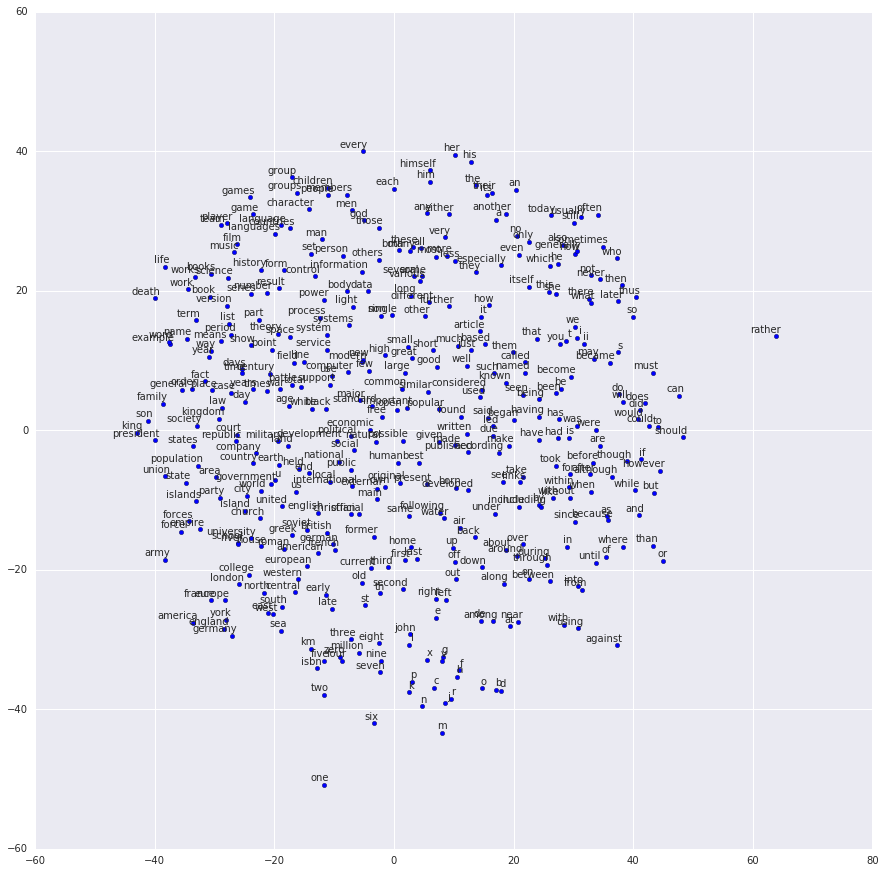

In [4]:
# *************** Word2vec version : SKIP-GRAM ie find the words surrounding a given single word ***************
# Input (one hot encoding) > Hidden layer (embedding) > logit > softmax > Cross entropy using negative sampling (computing efficiency purpose)
# Pure linear model ie no non-linear activation function (in particular no ReLU nor sigmoid).

batch_size = 128
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

embedding_size = 128 # Dimension of the embedding vector (ie number of neurons of the hidden layer)

num_sampled = 64 # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))


graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable( tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    # This is a pure linear model (ie no ReLU nor sigmoid activation function).
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings. We use the cosine distance.
    # Enable to visually check the evolution of the 8 nearest neighbors of 16 fixed frequent words during the learning process.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm # Embeddings of ALL vocabulary words
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) # Embeddings of 16 fixed words initially randomnly picked among the 100 most frequent words
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # Scalar product between the 2 previously computed embeddings sets


num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_SG(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 10000 == 0:
            if step > 0:
                average_loss = average_loss / 10000 # The average loss is an estimate of the loss over the last 10000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step % 20000 == 0: # note that this is expensive (~20% slowdown if computed every 500 steps)
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                log = 'Nearest to %s:' % valid_word
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()


def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

num_points = 400
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [5]:
data_index = 0

def generate_batch_CBOW(batch_size, num_skips, skip_window):
    global data_index
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        labels[i, 0] = buffer[skip_window]
        targets_to_avoid = [ skip_window ]
        target = skip_window  # target label at the center of the buffer
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i, j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(4, 2),(2, 1),(1, 1),(2, 3)]:
    data_index = 0
    batch, labels = generate_batch_CBOW(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [ [reverse_dictionary[bi] for bi in batch[i]] for i in range(8) ])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

batch, labels = generate_batch_CBOW(batch_size=8, num_skips=4, skip_window=2)
print(batch)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 4 and skip_window = 2:
    batch: [['originated', 'term', 'a', 'anarchism'], ['as', 'of', 'term', 'originated'], ['a', 'as', 'of', 'abuse'], ['first', 'abuse', 'term', 'a'], ['first', 'used', 'of', 'term'], ['abuse', 'used', 'against', 'of'], ['early', 'abuse', 'against', 'first'], ['early', 'first', 'working', 'used']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 1:
    batch: [['as', 'anarchism'], ['originated', 'a'], ['term', 'as'], ['a', 'of'], ['abuse', 'term'], ['of', 'first'], ['used', 'abuse'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 1 and skip_window = 1:
    batch: [['as'], ['originated'], ['as'], ['a'], ['abuse'], ['of'], ['used'], ['against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips =

Initialized
Average loss at step 0: 7.676182
Nearest to as: appliances, pharaonic, fifo, liquidated, majorana, pegbox, controlling, derive,
Nearest to been: prefaces, stagnation, hermit, jehu, tx, expansionist, heiland, tur,
Nearest to is: tasty, mitigating, rum, struck, apologetic, radiotherapy, abstention, cohort,
Nearest to new: nonce, christe, mated, bradford, inti, uno, conservatism, caesium,
Nearest to people: romagna, rogue, proto, syncopated, ankles, princeto, eberhard, hsbc,
Nearest to the: inductive, hussein, ould, maintenance, book, ur, bassett, story,
Nearest to or: decatur, single, surround, vanir, cyril, armas, paine, viewpoints,
Nearest to more: consigned, including, regulatory, versatile, pragmatic, tyrants, send, unfairness,
Nearest to four: benches, guided, unrepentant, sisak, loma, brief, jm, autobiography,
Nearest to first: spp, umayyads, jacobite, bacteriology, fic, horror, kyrie, asb,
Nearest to and: fines, superseding, reforms, biot, procol, tosefta, enclose, mod

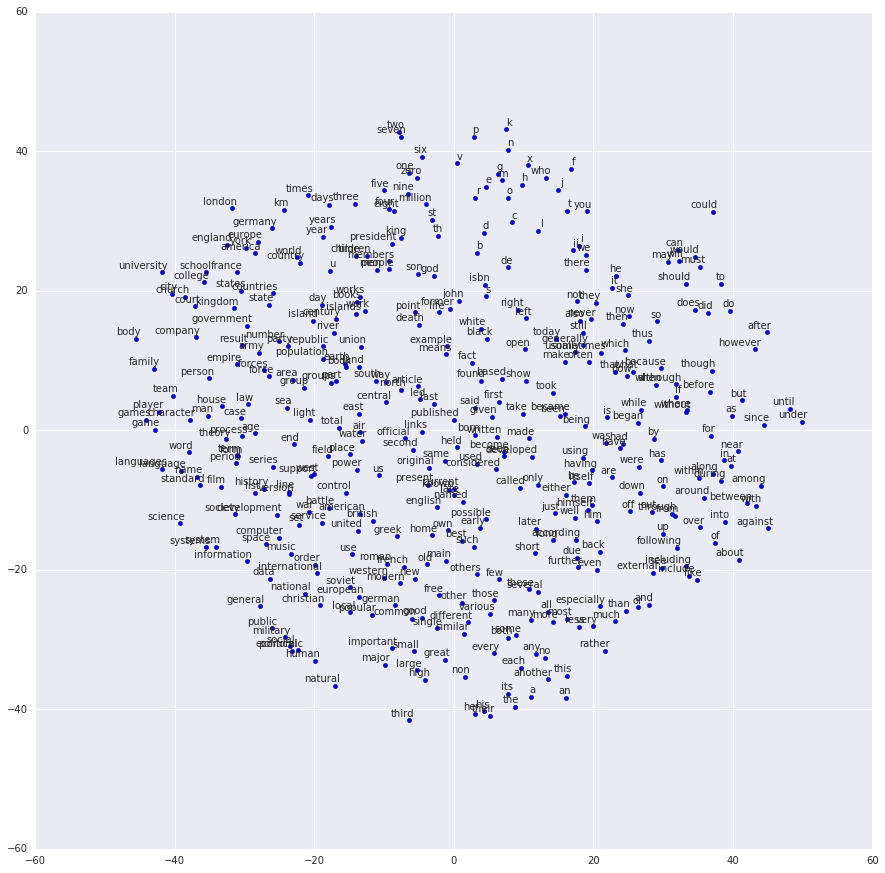

In [6]:
# *************** Word2vec version : CBOW ie find the target word given its context (ie the words surrounding it) ***************
# Input (one hot encoding) > Hidden layer (embedding as the mean of embeddings of the context words) > logit > softmax > Cross entropy using negative sampling (computing efficiency purpose)
# Pure linear model ie no non-linear activation function (in particular no ReLU nor sigmoid).

batch_size = 128
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many context words we use for a target word.

embedding_size = 128 # Dimension of the embedding vector (ie number of neurons of the hidden layer)

num_sampled = 64 # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))


graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable( tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Look up embeddings for inputs.
    #embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    xx = np.tile(np.arange(batch_size),(num_skips,1)).swapaxes(0,1).reshape(batch_size*num_skips,1)
    yy = np.tile(np.arange(num_skips),(batch_size,1)).reshape(batch_size*num_skips,1)
    indices = np.hstack((xx,yy))

    train_dataset_reformated = tf.reshape(train_dataset,[batch_size*num_skips])
    ids = tf.SparseTensor(indices=indices, values=train_dataset_reformated, shape=[batch_size, num_skips])

    embed = tf.nn.embedding_lookup_sparse(embeddings, ids, None, combiner='mean')
    # Compute the softmax loss, using a sample of the negative labels each time.
    # This is a pure linear model (ie no ReLU nor sigmoid activation function).
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings. We use the cosine distance.
    # Enable to visually check the evolution of the 8 nearest neighbors of 16 fixed frequent words during the learning process.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm # Embeddings of ALL vocabulary words
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) # Embeddings of 16 fixed words initially randomnly picked among the 100 most frequent words
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # Scalar product between the 2 previously computed embeddings sets


num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_CBOW(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 10000 == 0:
            if step > 0:
                average_loss = average_loss / 10000 # The average loss is an estimate of the loss over the last 10000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step % 20000 == 0: # note that this is expensive (~20% slowdown if computed every 500 steps)
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                log = 'Nearest to %s:' % valid_word
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()


def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()


num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)